In [1]:
import os
import pandas as pd
from pathlib import Path
from datetime import datetime
from sklearn.impute import KNNImputer
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import sys 
from typing import List, Optional, Callable, Dict, Union

 
# This code was developed with the assistance of multiple AI agents (e.g., Perplexity, August 2025).


In [2]:
%pwd

'C:\\Users\\mangl\\Desktop\\capstone\\pair_selection'

In [3]:
DATA_DIR = Path("../2021/Cash Data January 2021")  # Unzipped rar for some month

In [4]:
tickers = [i.rsplit(".", maxsplit=1)[0] for i in os.listdir(DATA_DIR)]
tickers[:10] # few available tickers

['.CNX100',
 '.CNXIT',
 '.NSEBANK',
 '.NSEI',
 '20MICRONS',
 '21STCENMGM',
 '3IINFOTECH',
 '3MINDIA',
 '3PLAND',
 '5PAISA']

In [5]:


def get_stock_data(
    tickers,
    start=None,
    end=None,
    agg_func=None,
    resample_freq=None,
    columns=None,
    impute=True
):
    """
    Load and process intraday stock data from CSV files.

    Parameters
    ----------
    tickers : List[str]
        List of stock ticker symbols (without file extensions).
    start : str or pd.Timestamp, optional
        Start datetime for filtering the data.
    end : str or pd.Timestamp, optional
        End datetime for filtering the data.
    agg_func : str or callable, optional
        Aggregation function to apply during resampling (e.g., 'mean', 'ohlc').
        Required if `resample_freq` is provided.
    resample_freq : str, optional
        Resample frequency (e.g., '5min', '15min').
    columns : List[str], optional
        List of columns to retain from the original data.
    impute : bool, default True
        Whether to impute missing data using expanding median.

    Returns
    -------
    Dict[str, pd.DataFrame]
        Dictionary mapping each ticker to its corresponding processed DataFrame.
    """
    data_dict = {}
    start = pd.to_datetime(start)
    end = pd.to_datetime(end)

    for ticker in tickers:
        df = pd.read_csv(Path(DATA_DIR) / f"{ticker}.csv")
        df.columns = [col.strip('<> ').strip() for col in df.columns]
        df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="%m/%d/%Y %H:%M:%S")
        df = df.sort_values(by="datetime")
        df = df.rename(columns={"o/i": "open_interest"})
        df = df.drop(columns=["ticker", "date", "time"], errors="ignore")
        df = df.set_index("datetime")
        df = df.sort_index()

            
        if resample_freq:
            impute = True

        if columns:
            df = df[columns]
        if impute:    

            full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq="1min")
            df = df.reindex(full_index)
            for col in df.columns:
               df[col] = df[col].fillna(df[col].expanding().median())
        if start:
            df = df[df.index >= start]
        if end:
            df = df[df.index <= end]
        

        if resample_freq:
            if agg_func is None:
                raise ValueError("agg_func must be provided when resampling.")
            df = df.resample(resample_freq).agg(agg_func)

        data_dict[ticker] = df

    return data_dict


In [6]:
dfs = get_stock_data(
    tickers,
    impute=False
)

Mean trading volume for all the stocks for the month

In [7]:
overall_mean_monthly_traded_volume = sum(df.volume.mean() for _, df in dfs.items())/len(dfs)

 Here we find the stocks whichh have high trading mean trading volumes for atleast half the month

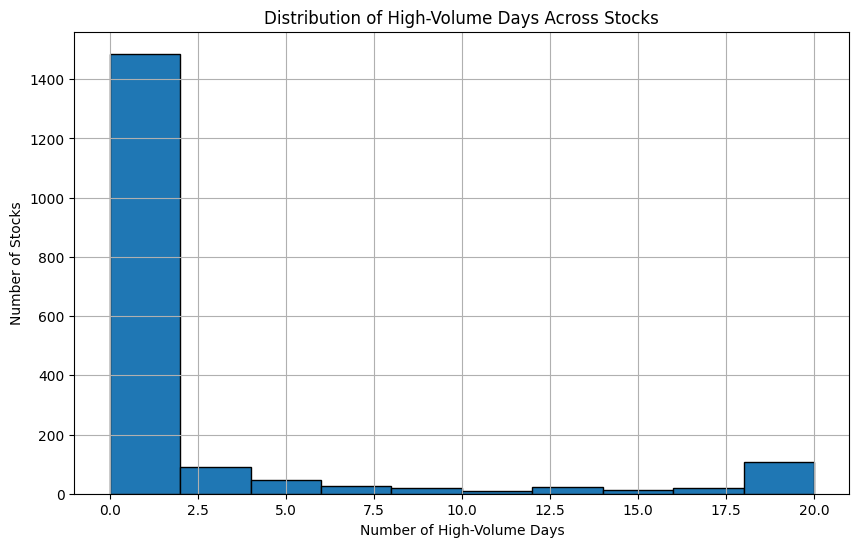

In [8]:
import matplotlib.pyplot as plt

# Calculate high volume day count for each stock
high_volume_day_counts = {
    s: (df.groupby(df.index.date)['volume'].mean() > overall_mean_monthly_traded_volume).sum().item()
    for s, df in dfs.items()
}

# Histogram 
plt.figure(figsize=(10, 6))
plt.hist(high_volume_day_counts.values(), bins=10, edgecolor='black')
plt.xlabel('Number of High-Volume Days')
plt.ylabel('Number of Stocks')
plt.title('Distribution of High-Volume Days Across Stocks')
plt.grid(True)
plt.show()


We observe that for more than half of January, there was sufficient liquidity in the market for some of the stocks. A huge number of stocks have been illiquid 

In [9]:
liquid_stocks = [ s for s, v in high_volume_day_counts.items() if v > 15]

In [10]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

def calculate_half_life(price_series):
    """
    Calculates the half-life of mean reversion for a price series using linear regression.
    
    Reference:
        Chan, E. P. (2013). Algorithmic Trading: Winning Strategies and Their Rationale. 
        John Wiley & Sons.
    """
    delta_p = price_series.diff().dropna()
    p_lag = price_series.shift(1).dropna()
    
    # Align indices explicitly - keep only indices that appear in both
    common_idx = delta_p.index.intersection(p_lag.index)
    delta_p = delta_p.loc[common_idx]
    p_lag = p_lag.loc[common_idx]
    
    model = OLS(delta_p.values, add_constant(p_lag.values))
    res = model.fit()
    beta = res.params[1]
    halflife = -np.log(2) / beta if beta < 0 else np.inf
    return halflife

def hurst_exponent(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

def mean_reversion_vector(price_series):
    price_series = price_series.dropna()
    
    adf_stat = adfuller(price_series)[0]
    half_life = calculate_half_life(price_series)
    hurst = hurst_exponent(price_series.values)
    
    returns = price_series.pct_change().dropna()
    vol = returns.std()
    
    return np.array([adf_stat, half_life, hurst, vol])

# Now your embedding extraction code can stay the same:
embedding_list = []
valid_stocks = []

for ticker in liquid_stocks:
    df = dfs[ticker]
    price_series = df['close']
    
    try:
        vec = mean_reversion_vector(price_series)
        if np.all(np.isfinite(vec)):
            embedding_list.append(vec)
            valid_stocks.append(ticker)
    except Exception as e:
        print(f"Failed for {ticker}: {e}")

embeddings = np.vstack(embedding_list)


In [11]:
embedding_list = []
valid_stocks = []

for ticker in liquid_stocks:
    df = dfs[ticker]
    price_series = df['close']   
    
    try:
        vec = mean_reversion_vector(price_series)
        if np.all(np.isfinite(vec)):
            embedding_list.append(vec)
            valid_stocks.append(ticker)
    except Exception as e:
        print(f"Failed for {ticker}: {e}")

embeddings = np.vstack(embedding_list)


In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering

# Cosine similarity matrix
cos_sim = cosine_similarity(embeddings)

# Cluster 
cluster_model = AgglomerativeClustering(n_clusters=5, linkage='average')

distances = 1 - cos_sim

labels = cluster_model.fit_predict(distances)

# Now labels[i] gives cluster of valid_stocks[i]



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\mangl\Desktop\Capstone\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


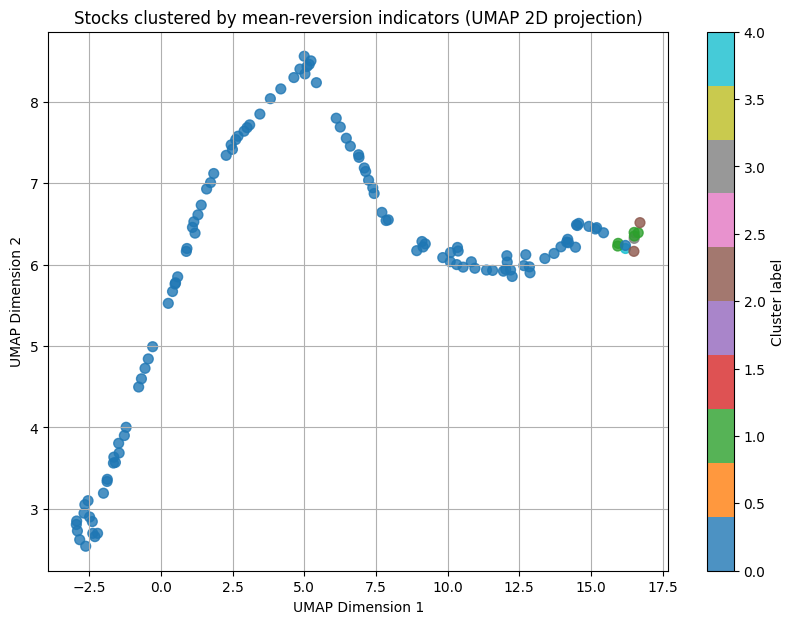

In [13]:
! pip install umap-learn

import umap.umap_ as umap 

reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_umap = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(embeddings_umap[:, 0], embeddings_umap[:, 1], c=labels, cmap='tab10', s=50, alpha=0.8)
plt.title("Stocks clustered by mean-reversion indicators (UMAP 2D projection)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(scatter, label='Cluster label')
plt.grid(True)
plt.show()


In [14]:
from collections import defaultdict

clustered_tickers = defaultdict(list)
for ticker, label in zip(tickers, labels):
    clustered_tickers[label].append(ticker)

for label in sorted(clustered_tickers):
    print(f"\nCluster {label} ({len(clustered_tickers[label])} tickers):")
    print(", ".join(clustered_tickers[label]))



Cluster 0 (116 tickers):
.CNX100, .CNXIT, .NSEBANK, .NSEI, 20MICRONS, 21STCENMGM, 3IINFOTECH, 3MINDIA, 3PLAND, 63MOONS, A2ZINFRA, AAKASH, AARON, AARTIDRUGS, AARTIIND, AARTISURF, AARVEEDEN, AARVI, AAVAS, ABAN, ABB, ABBOTINDIA, ABCAPITAL, ABFRL, ABMINTLTD, ABSLBANETF, ABSLNN50ET, ACC, ACCURACY, ACE, ACRYSIL, ADANIENT, ADANIGREEN, ADANIPORTS, ADANIPOWER, ADANITRANS, ADFFOODS, ADHUNIKIND, ADL, ADORWELD, ADROITINFO, ADSL, ADVANIHOTR, ADVENZYMES, AEGISCHEM, AFFLE, AGARIND, AGCNET, AGRITECH, AGROPHOS, AHLADA, AHLEAST, AHLUCONT, AHLWEST, AIAENG, AIRAN, AJANTPHARM, AJMERA, AKASH, AKSHARCHEM, AKSHOPTFBR, ALANKIT, ALBERTDAVD, ALCHEM, ALEMBICLTD, ALICON, ALKALI, ALKEM, ALKYLAMINE, ALLCARGO, ALLSEC, ALMONDZ, ALOKINDS, ALPA, ALPHAGEO, ALPSINDUS, AMARAJABAT, AMBER, AMBIKCO, AMBUJACEM, AMDIND, AMRUTANJAN, ANDHRACEMT, ANDHRAPAP, ANDHRSUGAR, ANIKINDS, ANKITMETAL, ANSALAPI, ANUP, APARINDS, APCL, APCOTEXIND, APEX, APLAPOLLO, APLLTD, APOLLO, APOLLOHOSP, APOLLOPIPE, APOLLOTYRE, APOLSINHOT, APTECHT, ARCHIDP

In [15]:
from itertools import combinations
from statsmodels.tsa.stattools import coint
import pandas as pd

def evaluate_pair(label, ticker1, ticker2):
    try:
        s1 = dfs[ticker1]['close']
        s2 = dfs[ticker2]['close']
        joined = pd.concat([s1, s2], axis=1, join='inner').dropna()
        if len(joined) < 50:
            return None
        s1_aligned = joined.iloc[:, 0]
        s2_aligned = joined.iloc[:, 1]
        score, pvalue, _ = coint(s1_aligned, s2_aligned)
        return {
            'cluster': label,
            'pair': (ticker1, ticker2),
            'cointegration_pvalue': pvalue
        }
    except Exception as e:
        return None

all_pairs = []
for label, ticker_list in clustered_tickers.items():
    if 2 <= len(ticker_list) <= 10:
        for ticker1, ticker2 in combinations(ticker_list, 2):
            all_pairs.append((label, ticker1, ticker2))
pair_results = []
for label, ticker1, ticker2 in all_pairs:
    result = evaluate_pair(label, ticker1, ticker2)
    if result is not None:
        pair_results.append(result)


11


In [16]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller

for result in pair_results:
    t1, t2 = result['pair']
    s1 = dfs[t1]['close']
    s2 = dfs[t2]['close']
    joined = pd.concat([s1, s2], axis=1, join='inner').dropna()
    y = joined.iloc[:,0].values
    x = joined.iloc[:,1].values
    beta = OLS(y, add_constant(x)).fit().params[1]
    spread = y - beta * x
    adf_stat, adf_pvalue, *_ = adfuller(spread)
    result['spread_adf_stat'] = adf_stat
    result['spread_adf_pvalue'] = adf_pvalue
    result['spread_std'] = np.std(spread)


In [17]:
good_pairs = [
    r for r in pair_results
    if r['cointegration_pvalue'] < 0.05 and r['spread_adf_pvalue'] < 0.05
]
#  sort by (1) p-value, (2) spread_std, (3) cluster size
good_pairs = sorted(good_pairs, key=lambda r: (r['cointegration_pvalue'], -r['spread_std']))


In [18]:
import pandas as pd
df_report = pd.DataFrame(good_pairs)
print(df_report[['cluster', 'pair', 'cointegration_pvalue', 'spread_adf_pvalue', 'spread_std']])


   cluster                  pair  cointegration_pvalue  spread_adf_pvalue  \
0        1  (ADANIGAS, ANANTRAJ)              0.021588           0.004968   
1        1   (ACCELYA, ADANIGAS)              0.039179           0.010024   
2        1   (ACCELYA, ANSALHSG)              0.042206           0.011077   

   spread_std  
0    2.954435  
1    6.726059  
2    9.917355  


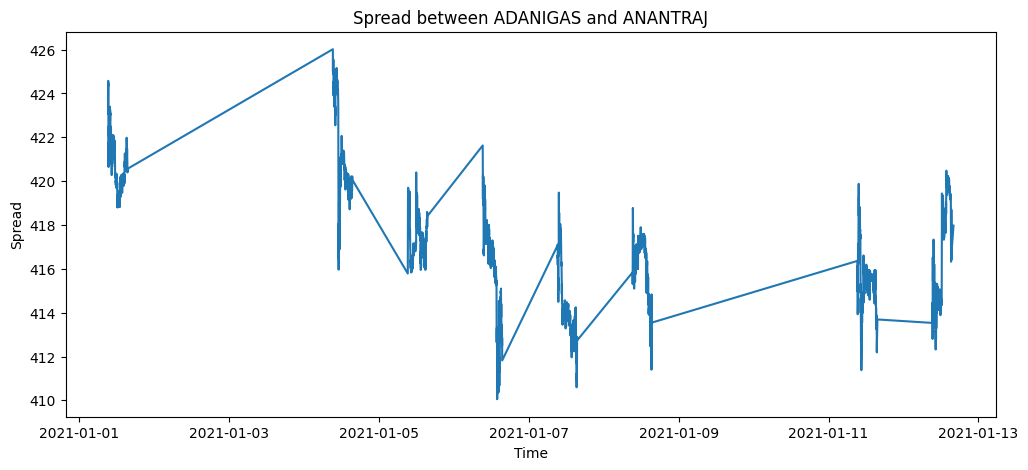

In [19]:
pair = good_pairs[0]['pair']
s1 = dfs[pair[0]]['close']
s2 = dfs[pair[1]]['close']
joined = pd.concat([s1, s2], axis=1, join='inner').dropna()
y = joined.iloc[:,0].values
x = joined.iloc[:,1].values
beta = OLS(y, add_constant(x)).fit().params[1]
spread = y - beta * x

plt.figure(figsize=(12,5))
plt.plot(joined.index, spread)
plt.title(f"Spread between {pair[0]} and {pair[1]}")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.show()
